In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np

In [2]:
# define GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Function for loading data
sets = {}
for _set in ['train', 'dev', 'test']:
    file_feats = '/media/jose/hk-data/PycharmProjects/the_speech/data/sleepiness/{0}/mfcc_sleepiness_23_{0}_0del.mfcc'.format(_set)
    print(file_feats)
    sets['x_'+_set] = np.load(file_feats, allow_pickle=True)
    
# x_train = torch.from_numpy(sets['x_train'])
# x_dev = torch.from_numpy(sets['x_dev'])
# x_test = torch.from_numpy(sets['x_test'])


/media/jose/hk-data/PycharmProjects/the_speech/data/sleepiness/train/mfcc_sleepiness_23_train_0del.mfcc
/media/jose/hk-data/PycharmProjects/the_speech/data/sleepiness/dev/mfcc_sleepiness_23_dev_0del.mfcc
/media/jose/hk-data/PycharmProjects/the_speech/data/sleepiness/test/mfcc_sleepiness_23_test_0del.mfcc


In [5]:
print(sets['x_train'][0])

[[ 2.1673120e+01 -8.1400909e+00  8.6047840e-01 ...  2.2953606e-01
   8.2762718e-02 -3.6067128e-02]
 [ 2.0726582e+01  1.5244560e+00  2.0444315e+01 ... -1.1006370e+00
  -1.2069714e+00 -1.2010527e-01]
 [ 2.0596664e+01  1.9958973e+00  1.6893761e+01 ...  1.0933818e+00
   4.0503311e-01 -4.2310047e-01]
 ...
 [ 1.9835722e+01 -3.6898083e+01  1.3698262e+01 ... -2.0012975e+00
  -2.5502479e-01 -1.2310663e-01]
 [ 2.1561762e+01 -2.7597805e+01  2.0444315e+01 ...  6.9345319e-01
  -2.8573275e-01 -4.5071214e-02]
 [ 2.1803038e+01 -1.2484856e+01  9.9821949e+00 ...  1.6283894e+00
  -4.0856457e-01  1.4956027e-02]]


In [26]:
# define CNN
'''
TDNN as defined by https://www.danielpovey.com/files/2015_interspeech_multisplice.pdf
Affine transformation not applied globally to all frames but smaller windows with local context
batch_norm: True to include batch normalisation after the non linearity

Context size and dilation determine the frames selected
(although context size is not really defined in the traditional sense)
For example:
    context size 5 and dilation 1 is equivalent to [-2,-1,0,1,2]
    context size 3 and dilation 2 is equivalent to [-2, 0, 2]
    context size 1 and dilation 1 is equivalent to [0]
'''

class xvecTDNN(nn.Module):
    def __init__(self, n_classes, p_dropout):
        super(xvecTDNN, self).__init__()
        self.tdnn1 = nn.Conv1d(in_channels=30, out_channels=512, kernel_size=5, dilation=1)
        self.bn_tdnn1 = nn.BatchNorm1d(512, momentum=0.1, affine=False)
        self.dropout_tdnn1 = nn.Dropout(p=p_dropout)

        self.tdnn2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, dilation=2)
        self.bn_tdnn2 = nn.BatchNorm1d(512, momentum=0.1, affine=False)
        self.dropout_tdnn2 = nn.Dropout(p=p_dropout)

        self.tdnn3 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=7, dilation=3)
        self.bn_tdnn3 = nn.BatchNorm1d(512, momentum=0.1, affine=False)
        self.dropout_tdnn3 = nn.Dropout(p=p_dropout)

        self.tdnn4 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=1, dilation=1)
        self.bn_tdnn4 = nn.BatchNorm1d(512, momentum=0.1, affine=False)
        self.dropout_tdnn4 = nn.Dropout(p=p_dropout)

        self.tdnn5 = nn.Conv1d(in_channels=512, out_channels=1500, kernel_size=1, dilation=1)
        self.bn_tdnn5 = nn.BatchNorm1d(1500, momentum=0.1, affine=False)
        self.dropout_tdnn5 = nn.Dropout(p=p_dropout)

        self.fc1 = nn.Linear(3000,512)
        self.bn_fc1 = nn.BatchNorm1d(512, momentum=0.1, affine=False)
        self.dropout_fc1 = nn.Dropout(p=p_dropout)

        self.fc2 = nn.Linear(512,512)
        self.bn_fc2 = nn.BatchNorm1d(512, momentum=0.1, affine=False)
        self.dropout_fc2 = nn.Dropout(p=p_dropout)

        self.fc3 = nn.Linear(512,n_classes)

    def forward(self, x, eps):
        # Note: x must be (batch_size, feat_dim, chunk_len)

        x = self.dropout_tdnn1(self.bn_tdnn1(F.relu(self.tdnn1(x))))
        x = self.dropout_tdnn2(self.bn_tdnn2(F.relu(self.tdnn2(x))))
        x = self.dropout_tdnn3(self.bn_tdnn3(F.relu(self.tdnn3(x))))
        x = self.dropout_tdnn4(self.bn_tdnn4(F.relu(self.tdnn4(x))))
        x = self.dropout_tdnn5(self.bn_tdnn5(F.relu(self.tdnn5(x))))

        if self.training:
            shape = x.size()
            noise = torch.cuda.FloatTensor(shape)
            torch.randn(shape, out=noise)
            x += noise*eps

        stats = torch.cat((x.mean(dim=2), x.std(dim=2)), dim=1)
        x = self.dropout_fc1(self.bn_fc1(F.relu(self.fc1(stats))))
        x = self.dropout_fc2(self.bn_fc2(F.relu(self.fc2(x))))
        x = self.fc3(x)
        return x


net = xvecTDNN(n_classes=8, p_dropout=0.5)
# to GPU
net.to(device)

xvecTDNN(
  (tdnn1): Conv1d(30, 512, kernel_size=(5,), stride=(1,))
  (bn_tdnn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (dropout_tdnn1): Dropout(p=0.5, inplace=False)
  (tdnn2): Conv1d(512, 512, kernel_size=(5,), stride=(1,), dilation=(2,))
  (bn_tdnn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (dropout_tdnn2): Dropout(p=0.5, inplace=False)
  (tdnn3): Conv1d(512, 512, kernel_size=(7,), stride=(1,), dilation=(3,))
  (bn_tdnn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (dropout_tdnn3): Dropout(p=0.5, inplace=False)
  (tdnn4): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
  (bn_tdnn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (dropout_tdnn4): Dropout(p=0.5, inplace=False)
  (tdnn5): Conv1d(512, 1500, kernel_size=(1,), stride=(1,))
  (bn_tdnn5): BatchNorm1d(1500, eps=1e-05, momentum=0.1, affine=False, track_running_

In [16]:
# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


In [41]:
# Train the network
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data # CPU
        inputs, labels = data[0].to(device), data[1].to(device) # GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.204
[1,  4000] loss: 1.870
[1,  6000] loss: 1.655
[1,  8000] loss: 1.580
[1, 10000] loss: 1.491


KeyboardInterrupt: 

In [33]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [29]:
# test data
dataiter = iter(testloader)
images, labels = dataiter.next()

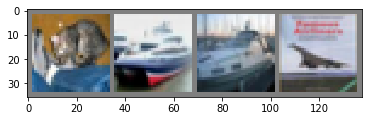

GroundTruth:    cat  ship  ship plane


In [30]:
# print images
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [34]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [35]:
outputs = net(images)

In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %
